In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

import neuro_morpho_toolbox as nmt
# ns=nmt.neuron_set('/Users/pengxie/Documents/Research/fullMorph_classification/data/registered_swc/Janelia_test/swc/Whole/')
ns=nmt.neuron_set('/home/penglab/Documents/Janelia_1000')



/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 1.02
Loading CCF brain structure data...
Loading time: 0.01
Loading...
100 loaded: 2.7s
Invalid number of soma found: 0
QC failed: AA0114.swc
Invalid number of soma found: 0
QC failed: AA0115.swc
200 loaded: 2.3s
300 loaded: 2.3s
400 loaded: 2.7s
Invalid number of soma found: 0
QC failed: AA0472.swc
500 loaded: 2.5s
Invalid number of soma found: 0
QC failed: AA0576.swc
Invalid number of soma found: 0
QC failed: AA0585.swc
Invalid number of soma found: 0
QC failed: AA0589.swc
600 loaded: 2.3s
Invalid number of soma found: 0
QC failed: AA0639.swc
Invalid number of soma found: 0
QC failed: AA0670.swc
Invalid number of soma found: 0
QC failed: AA0672.swc
700 loaded: 2.1s
Invalid number of soma found: 0
QC failed: AA0754.swc
Invalid number of soma found: 0
QC failed: AA0763.swc
800 loaded: 2.6s
900 loaded: 1.8s
QC failed: AA0952.swc
QC failed: AA0964.swc
QC failed: AA0968.swc
QC

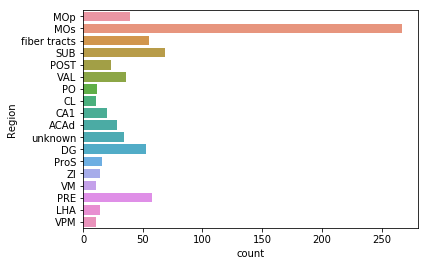

In [2]:
sf = ns.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)


## Add abbreviation information to ccfDF

ccfDF = pd.read_excel('/home/penglab/Documents/dataSource/ccfDF.xlsx')
abbrlist = []
for i in ccfDF.loc[:,'structure ID']:
    if i in nmt.bs.level.index:
        abbr = nmt.bs.level.loc[i,'Abbrevation']
        abbrlist.append(abbr)
    else:
        print(i)
        abbrlist.append('unknown')
ccfDF.loc[:,'ABBR']=abbrlist

## Modify the dictionary feature extraction part

In [3]:
soma_hier10flip=pd.read_excel('/home/penglab/Documents/dataSource/soma_hier10flip.xlsx', index_col=0)
soma_kmeans10flip=pd.read_excel('/home/penglab/Documents/dataSource/soma_kmeans10flip.xlsx', index_col=0)
soma_dbscan10flip=pd.read_excel('/home/penglab/Documents/dataSource/soma_dbscan10flip.xlsx', index_col=0)
soma_hdbscan10flip=pd.read_excel('/home/penglab/Documents/dataSource/soma_hdbscan10flip.xlsx', index_col=0)
soma_snn10flip = pd.read_excel('/home/penglab/Documents/dataSource/soma_snn10flip.xlsx', index_col=0)

In [4]:
def normalize(df, log=True):
    scaled_data = np.array(df) / np.sum(df, axis=0).values.reshape(-1,1) * 100000
    if log:
        scaled_data = np.log(scaled_data+100)
    scaled_dataDF = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
    return scaled_dataDF

### function Region_record(flipDF,cluster_method,somaDF,axonDF,pattern)
* **flipDF** is the dataframe obtained by flipping the brain region,here use the ['parameter'] column
* **cluster_method** can be 'Hierarchy','Kmeans', 'DBSCAN','HDBSCAN','' 
* **somaDF** is the dataframe containing the region of soma: ns.features['soma_features'].region
* **axonDF** is the dataframe containing the region of axon: ns.features['projection_features'].raw_data

In [5]:
import ast
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
def Region_record(flipDF,cluster_method,somaDF,axonDF,normaF):
    somaregionDF = somaDF.copy()
    axonregionDF = axonDF.copy()      
    df_pre = flipDF.copy()
    df_pre = df_pre[df_pre['SC']!='below'].copy()
    df_pre = df_pre[df_pre['SC']!='above'].copy()
    df_pre.sort_values(by='ARI', ascending=False, inplace=True)
    index_ls = df_pre.index[:1]
    colname = ['V','ARI','AMI','SC','parameter','Cluster Num','soma Region List','axon Region List']
    df = pd.DataFrame(columns = colname,index = index_ls)
    df['parameter'] = df_pre.loc[index_ls,'parameter']
    
    #under each parameter
    for iter_idx in df.index:
        _ = ns. get_clusters(method = cluster_method,karg_dict = ast.literal_eval(df.loc[iter_idx]['parameter']))
        somaregionDF['cluster'] = ns.metadata['Cluster']
        axonregionDF['cluster'] = ns.metadata['Cluster']
        V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        typeR, typeC = np.unique(somaregionDF['cluster'] , return_counts = True)
        if cluster_method == 'HDBSCAN':
            delist=np.array([])
            for itertype in typeR:
                if itertype[1]=='-':
                    delist = np.append(delist,itertype)
                if itertype[1]=='0':
                    delist=np.append(delist,itertype)
            detailDF = pd.DataFrame(index = np.setdiff1d(typeR,delist),columns = ['swc list','soma region',
                                                                                  'max soma','total soma',
                                                                                  'max axon'])
        else:
            detailDF = pd.DataFrame(index = typeR,columns = ['swc list','soma region','max soma','total soma',
                                                             'max axon'])
        #detailDF.loc[:,'Cluster Type'] = detailDF.index
        if len(typeR)<2:
            SS = 'below'
        elif len(typeR)>=ns.UMAP.shape[0]:
            SS = 'above'
        else:
            SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
            #LABEL LIST CAN BE DETELETED LATER


        # for each cluster result UNDER EACH PARAMETER
        somaCLUSTERlist = []
        axonCLUSTERlist = []

        #axonCLUSTER = pd.DataFrame(index = axonregionDF.columns[:-1])
        for label_idx in detailDF.index:
            axonTEMPdf = pd.DataFrame(index = axonregionDF.columns[:-1])
            swcINlabel = somaregionDF[somaregionDF['cluster']==label_idx]
            detailDF.loc[label_idx,'swc list'] = (swcINlabel.index).tolist()
            #assert(len(inter_list)==somaDF[somaDF['cluster'] !=label_idx].shape[0])
            detailDF.loc[label_idx,'soma region'] = swcINlabel['Region'].tolist()
            del_soma_region=detailDF.loc[label_idx,'soma region']
            while 'unknown' in del_soma_region:
                del_soma_region.remove('unknown')
                del_soma_region.append('others')
            while 'fiber tracts' in del_soma_region:
                del_soma_region.remove('fiber tracts')
                del_soma_region.append('others')
            IDrange, IDcounts = np.unique(del_soma_region, return_counts = True)
            #sort the counting
            count_sort_ind = np.argsort(-IDcounts)
            dicitem = []
            for i in range(1,min(len(IDrange)+1,4)):
                dicitem.append(str(i)+'somaR')
            for i in range(1,min(len(IDrange)+1,4)):
                dicitem.append(str(i)+'somaC')
            #select the first three regions
            dicvalue = IDrange[count_sort_ind][0:min(3,len(IDrange))]
            dicvalue = np.append(dicvalue,IDcounts[count_sort_ind][0:min(3,len(IDrange))])
            detailDF.loc[label_idx,'max soma'] = str(dict(zip(dicitem, dicvalue)))
            somaCLUSTERlist.append(detailDF.loc[label_idx,'max soma'] )
            detailDF.loc[label_idx,'total soma'] = swcINlabel.shape[0]
            
            #axonLABEL stores all the rows under same cluster
            axonLABEL = axonregionDF[axonregionDF['cluster']==label_idx].copy()
            axonLABEL.drop('cluster', axis=1,inplace=True)
            axonTEMPdf[label_idx]=axonLABEL.sum()
            if 'contra_fiber tracts' in axonTEMPdf.index:
                axonTEMPdf.drop(index=['contra_fiber tracts'],inplace = True)
            if 'ipsi_fiber tracts' in axonTEMPdf.index:
                axonTEMPdf.drop(index=['ipsi_fiber tracts'],inplace = True)
            if normaF:
                #normalize the sum
                axonTEMPdf = normalize(axonTEMPdf , log=True)
            axonTEMPdf.sort_values(by=label_idx, ascending=False, inplace=True)
            dicitem = []
            for i in range(1,4):
                dicitem.append(str(i)+'axonR')
            for i in range(1,4):
                dicitem.append(str(i)+'axonC')
            dicvalue = axonTEMPdf.index[:3]
            dicvalue = np.append(dicvalue,axonTEMPdf.loc[:,label_idx][:3])
            detailDF.loc[label_idx,'max axon'] = str(dict(zip(dicitem, dicvalue)))
            axonCLUSTERlist.append(detailDF.loc[label_idx,'max axon'] )

        df.loc[iter_idx,'soma Region List'] = somaCLUSTERlist
        df.loc[iter_idx,'axon Region List'] = axonCLUSTERlist
        df.loc[iter_idx,'Cluster Num'] = detailDF.shape[0]
        df.loc[iter_idx,'V'] = V
        df.loc[iter_idx,'ARI'] = ARI
        df.loc[iter_idx,'AMI'] = AMI
        df.loc[iter_idx,'SC'] = SS
    return detailDF

In [6]:
#hier_as = Region_record(soma_hier10flip.copy(),'Hierarchy',ns.features['soma_features'].region,ns.features['projection_features'].raw_data,1)
#hier_as.to_excel('/home/penglab/Documents/dataSource/hier_as.xlsx')
hier_as = pd.read_excel('/home/penglab/Documents/dataSource/hier_as.xlsx', index_col=0)

#kmeans_as = Region_record(soma_kmeans10flip.copy(),'Kmeans',ns.features['soma_features'].region,ns.features['projection_features'].raw_data,1)
#kmeans_as.to_excel('/home/penglab/Documents/dataSource/kmeans_as.xlsx')
kmeans_as = pd.read_excel('/home/penglab/Documents/dataSource/kmeans_as.xlsx', index_col=0)

#dbscan_as = Region_record(soma_dbscan10flip.copy(),'DBSCAN',ns.features['soma_features'].region,ns.features['projection_features'].raw_data,1)
#dbscan_as.to_excel('/home/penglab/Documents/dataSource/dbscan_as.xlsx')
dbscan_as = pd.read_excel('/home/penglab/Documents/dataSource/dbscan_as.xlsx', index_col=0)

#hdbscan_as = Region_record(soma_hdbscan10flip.copy(),'HDBSCAN',ns.features['soma_features'].region,ns.features['projection_features'].raw_data,1)
#hdbscan_as.to_excel('/home/penglab/Documents/dataSource/hdbscan_as.xlsx')
hdbscan_as = pd.read_excel('/home/penglab/Documents/dataSource/hdbscan_as.xlsx', index_col=0)

#snn_as = Region_record(soma_hdbscan10flip.copy(),'SNN_community',ns.features['soma_features'].region,ns.features['projection_features'].raw_data,1)
#snn_as.to_excel('/home/penglab/Documents/dataSource/snn_as.xlsx')
snn_as = pd.read_excel('/home/penglab/Documents/dataSource/snn_as.xlsx', index_col=0)

## function fromSOMAtoAXON() will return a dataframe 
* first a DataFrame will be generated

* **clusterDF** stores the information of clustering result, with columns ['swc list', 'soma region', 'max soma', 'total soma', 'max axon']


In [49]:
def fromSOMAtoAXON(clusterDF) :
    dfname=[]
    for cluster_idx in clusterDF.index:
        dfname.append((str(cluster_idx) + 'DF'))

    #generate a dataframe for each cluster
    dicDF = {k:None for k in dfname}

    #iterate the correponding dataframe and cluster at the same time
    for key_iter,cluster_idx in zip(dicDF.keys(),clusterDF.index):
        dic_soma = ast.literal_eval(clusterDF.loc[cluster_idx,'max soma'])
        iterL = int(len(dic_soma.keys())/2)
        somaNAME = []
        somaCOUNT = []

        for i in range(1,int(iterL)+1):
            somaNAME.append(dic_soma[(str(i)+'somaR')])
        for i in range(1,iterL+1):
            somaCOUNT.append(dic_soma[str(i)+'somaC'])
        somaArr = np.array(somaCOUNT, dtype = float)
        somaArr = somaArr/sum(somaArr)
        dic_axon = ast.literal_eval(clusterDF.loc[cluster_idx,'max axon'])
        iterL = int(len(dic_axon.keys())/2)
        axonNAME = []
        axonCOUNT = []
        for i in range(1,iterL+1):
            axonNAME.append(dic_axon[(str(i)+'axonR')])
        for i in range(1,iterL+1):
            axonCOUNT.append(dic_axon[str(i)+'axonC']) 

        tempDF = pd.DataFrame()
        for row_soma in somaNAME:
            for col_axon,len_axon in zip(axonNAME,axonCOUNT):
                tempDF.loc[row_soma, col_axon] = len_axon

        assert(tempDF.shape[0] == len(somaArr))  
        tempDF=tempDF.astype(float)
        for i in range(tempDF.shape[0]):
            tempDF.iloc[i,:] = tempDF.iloc[i,:]*somaArr[i].copy()

        newDF = pd.DataFrame(columns=['from','to','value'],index=range(tempDF.shape[0]*tempDF.shape[1]))
        newDF.loc[:,'from'] = (tempDF.index).tolist()*len(tempDF.columns)
        newDF.loc[:,'to'] = [ele for ele in (tempDF.columns).tolist() for _ in range(len(tempDF.index))]
        valuelist=[]
        for iter_col in tempDF.columns:
            for iter_row in tempDF.index:
                valuelist.append(tempDF.loc[iter_row,iter_col])
        newDF.loc[:,'value']=valuelist
        dicDF[key_iter]= newDF.copy()
    return dicDF

In [50]:
dicHIER = fromSOMAtoAXON(hier_as)
dicKMEANS = fromSOMAtoAXON(kmeans_as)
dicDBSCAN = fromSOMAtoAXON(dbscan_as)
dicHDBSCAN = fromSOMAtoAXON(hdbscan_as)
dicSNN = fromSOMAtoAXON(snn_as)


In [53]:
for iter_key in dicHIER.keys():
    tempDF = dicHIER[iter_key]
    print(tempDF)

     from        to     value
0  others  ipsi_PAG  5.593516
1      ZI  ipsi_PAG  2.330632
2     LHA  ipsi_PAG  1.631442
3  others  ipsi_MRN  5.511542
4      ZI  ipsi_MRN  2.296476
5     LHA  ipsi_MRN  1.607533
6  others  ipsi_SCm  5.090743
7      ZI  ipsi_SCm  2.121143
8     LHA  ipsi_SCm  1.484800
  from         to      value
0   PO   ipsi_MOs  10.084675
1   PO  ipsi_ACAd   9.780293
2   PO   ipsi_MOp   9.766318
     from             to     value
0  others    contra_VISp  6.885229
1    VISl    contra_VISp  2.295076
2    VISp    contra_VISp  1.147538
3  others    contra_VISl  6.596685
4    VISl    contra_VISl  2.198895
5    VISp    contra_VISl  1.099448
6  others  contra_VISpor  6.091460
7    VISl  contra_VISpor  2.030487
8    VISp  contra_VISpor  1.015243
     from           to     value
0  others  contra_VISp  5.510997
1    VISp  contra_VISp  3.149141
2    VISl  contra_VISp  1.574571
3  others    contra_LP  5.267602
4    VISp    contra_LP  3.010058
5    VISl    contra_LP  1.505029
6  

In [ ]:
for iter_key in dicHIER.keys():
    tempDF = dicHIER[iter_key]
    print(tempDF)
    #(tempDF).to_csv('/home/penglab/Documents/dataSource/dfSET/HIER/'+str(iter_key)+'.csv')

## Add abbreviation information to mouseDF

In [7]:

mouseDF = pd.read_excel('/home/penglab/Documents/dataSource/mouseDF.xlsx',index=0)
abbrlist = []
for i in mouseDF.loc[:,'idx']:
    if i in nmt.bs.level.index:
        abbr = nmt.bs.level.loc[i,'Abbrevation']
        abbrlist.append(abbr)
    else:
        print(i)
        abbrlist.append('unknown')
mouseDF.loc[:,'ABBR']=abbrlist
del mouseDF[1]
mouseDF.set_index(['idx'],inplace=True)

## Defining color code

### Isocortex, OLF, HPF, CTXsp, CNU, BS, CB's childregion will have same color 

ONLY CARE ABOUT THE LARGE-VOLUME REGION, colorlist is a range of distint colors.

### For ribbon color, use RibbonColor to store all the color code for ribbons
### For link color, use LinkColor to store  all the color code for links

In [9]:
fullbs = nmt.brain_structure('/home/penglab/Documents/data/Mouse.csv')

In [12]:
large_list = [ 'BS', 'CB','CNU', 'CTXsp', 'HPF','Isocortex', 'OLF']

colorDIC = {}
        
for B_iter in large_list :
    temp=[]
    if nmt.bs.name_to_id(B_iter) in mouseDF.index:
        for child_iter in mouseDF.loc[nmt.bs.name_to_id(B_iter),'Child ID'].split():
            temp.append(fullbs .level.loc[int(child_iter),'Abbrevation'])
    colorDIC["region{0}".format(B_iter)]=temp       


In [86]:
colorlist=["#7FC97F","#BEAED4","#FDC086","#FFFF99","#386CB0","#F0027F","#BF5B17","#666666","#1B9E77","#D95F02",
           "#7570B3","#E7298A","#66A61E","#E6AB02","#A6761D","#666666","#A6CEE3","#1F78B4","#B2DF8A","#33A02C",
           "#FB9A99","#E31A1C","#FDBF6F","#FF7F00","#CAB2D6","#6A3D9A","#FFFF99","#B15928","#FBB4AE","#B3CDE3",
           "#CCEBC5","#DECBE4","#FED9A6","#FFFFCC","#E5D8BD","#FDDAEC","#F2F2F2","#B3E2CD","#FDCDAC","#CBD5E8",
           "#F4CAE4","#E6F5C9","#FFF2AE","#F1E2CC","#CCCCCC","#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00",
           "#FFFF33","#A65628","#F781BF","#999999","#66C2A5","#FC8D62","#8DA0CB","#E78AC3","#A6D854","#FFD92F",
           "#E5C494","#B3B3B3","#8DD3C7","#FFFFB3","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69","#FCCDE5",
           "#D9D9D9","#BC80BD","#CCEBC5"]

In [265]:
for i in colorlist:
    

73

In [87]:


RibbonColor = pd.DataFrame(index = ['others'],columns=['name','RibbonC'])
RibbonColor.loc['others','name'] = 'others'
RibbonColor.loc['others','RibbonC'] = "#FFED6F"
ii=0
for iterkey in colorDIC.keys():
    idxlist=[]
    for i in colorDIC[iterkey]:
        idxlist.append('ipsi_'+i)
        idxlist.append(i)
        idxlist.append('contra_'+i)
    tempDF = pd.DataFrame()
    tempDF['name']=idxlist
    tempDF.set_index(['name'], drop=False, append=False, inplace=True, verify_integrity=False)
    tempDF.loc[:,'RibbonC']=colorlist[ii]
    RibbonColor = RibbonColor.append(tempDF)
    ii=ii+1





In [102]:
def CheckRibboncolor(dicDF,ii,RibbonColor):
    ii=7
    for iter_key in dicDF.keys():
        tempDF = dicDF[iter_key]
    for itername in tempDF.loc[:,'from']:
        if itername not in RibbonColor.index:
            print(itername)
            tempDF = pd.DataFrame()
            tempDF['name']=idxlist
            tempDF.set_index(['name'], drop=False, append=False, inplace=True, verify_integrity=False)
            tempDF.loc[:,'RibbonC']=colorlist[ii]
            RibbonColor = RibbonColor.append(tempDF)
            ii=ii+1
    for itername in tempDF.loc[:,'to']:
        if itername not in RibbonColor.index:
            print(itername)
            tempDF = pd.DataFrame()
            tempDF['name']=idxlist
            tempDF.set_index(['name'], drop=False, append=False, inplace=True, verify_integrity=False)
            tempDF.loc[:,'RibbonC']=colorlist[ii]
            RibbonColor = RibbonColor.append(tempDF)
            ii+1
    print(ii)
        

#### Now after checking, we are sure that dataframe RibbonColor contains all the region appearing.

In [263]:
ii=7

LinkColor = pd.DataFrame(index = ['others'],columns=['from','to','LinkC'])
LinkColor.loc['others','from'] = 'others'
LinkColor.loc['others','to'] = 'others'
LinkColor.loc['others','LinkC'] = colorlist[ii]
ii=ii+1
for iterkey1 in colorDIC.keys():
    fromlist=[]
    for i1 in colorDIC[iterkey1]:
        fromlist.append(i1)
    fromlist.append('others')
    for iterkey2 in colorDIC.keys():
        tempFROMlist = fromlist.copy()
        tolist=[]
        for i2 in colorDIC[iterkey2]:
            tolist.append('ipsi_'+i2)
            tolist.append('contra_'+i2)
        tempFROMlist =[ele for ele in tempFROMlist for _ in range(len(tolist))].copy() 
        tolist = (tolist*(len(fromlist))).copy()
        tempDF = pd.DataFrame()
        tempDF['from'] = tempFROMlist
        tempDF['to']=tolist
        tempDF.set_index(['from'], drop=False, append=False, inplace=True, verify_integrity=False)
        tempDF.loc[:,'LinkC'] = colorlist[ii]
        LinkColor = LinkColor.append(tempDF)
        ii=ii+1
print(ii)

57


In [264]:
LinkColor.to_csv('/home/penglab/Documents/dataSource/LinkColor.csv')
RibbonColor.to_csv('/home/penglab/Documents/dataSource/RibbonColor.csv')

In [256]:
def CheckLinkcolor(dicDF):
    for iter_key in dicDF.keys():
        tempDF = dicDF[iter_key]
    for idx in tempDF.index:
        rowsuit 


In [259]:
LinkColor.columns

Index(['from', 'to', 'LinkC'], dtype='object')

In [237]:
ii=7

LinkColor = pd.DataFrame(index = ['others'],columns=['from','to','LinkC'])
LinkColor.loc['others','from'] = 'others'
LinkColor.loc['others','to'] = 'others'
LinkColor.loc['others','LinkC'] = colorlist[ii]
ii=ii+1
fromlist=[]
i=2
while i <= RibbonColor.shape[0]:
    fromlist.append(RibbonColor.index[i])
    i=i+3
tolist=[]
ii=1
while ii < RibbonColor.shape[0]:
    tolist.append(RibbonColor.index[ii])
    tolist.append(RibbonColor.index[ii+2])
    ii=ii+3


In [260]:
row = LinkColor[LinkColor['from']=="MM"].copy()
row = row[row['to']== "contra_VISp"].copy()
row

,from,to,LinkC
MM,MM,contra_VISp,#E6AB02


In [241]:
len(fromlist)*len(tolist)

2402432

In [244]:
LinkColor.shape

(2402433, 3)

In [218]:
RibbonColor.shape[0]

3289

In [28]:
RibbonColor = pd.DataFrame()
RibbonColor['name']=idxlist
RibbonColor.set_index(['name'], drop=False, append=False, inplace=True, verify_integrity=False)

In [33]:
import random
_HEX = '0123456789ABCDEF'
def startcolor():
    return '#' + ''.join(random.choice(_HEX) for _ in range(6))
startcolor()

'#CCCDD1'